# IMAGE PROCESSING - FACE RECOGNITION ATTENDANCE SYSTEM
### Team Members (Roll Numbers):

*   Sarah Biju (MS23090)
*   Tushti Govind (MS23144)
*   Eshita Tandon (MS23163)

### Tools/ Libraries:
 Python, OpenCV, NumPy, Pandas, Scikit-learn, Matplotlib, DeepFace, SQLite3, Joblib

### Dataset:
Labeled Faces in the Wild (LFW)

### Database:
SQLite

### Models/ Techniques:
Facenet, Principal Component Analysis (PCA), Support Vector Machine (SVM)


## Objective 1
- To build a dataset of 15–20 individuals (students) using the LFW dataset.
- To perform exploratory data analysis on number of images, image sizes, and sample visualization.

✅ Total people selected: 20
✅ Dataset saved in data/known_faces/


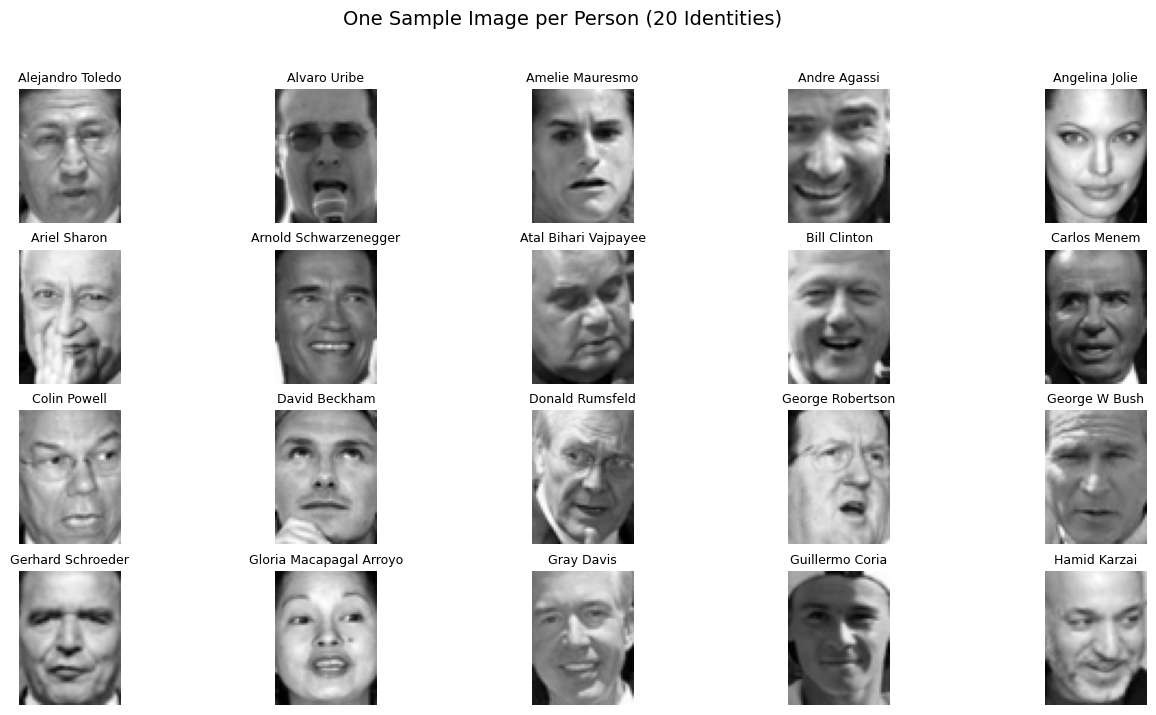


🧍 Showing all images of: Amelie Mauresmo (21 total)


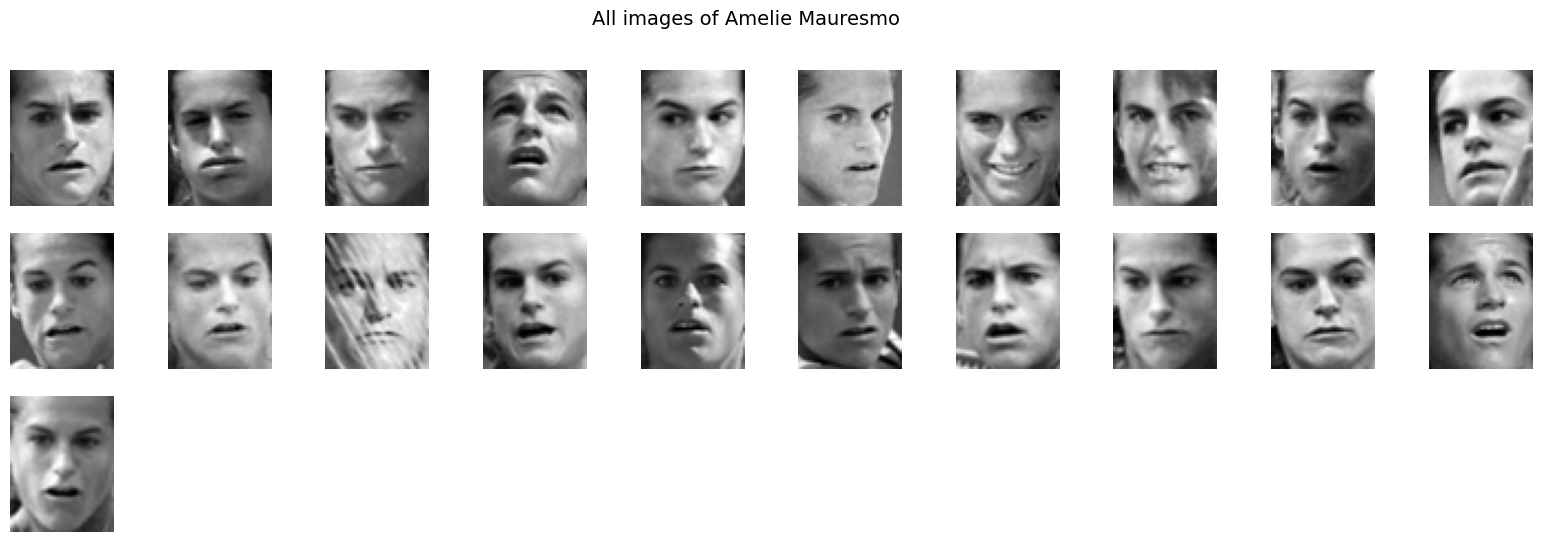

In [ ]:
# =======================================
# LFW Dataset Extraction + Visualization
# =======================================
from sklearn.datasets import fetch_lfw_people
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fetch LFW dataset (filtering by minimum 20 images/person)
lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)
X = lfw.images
y = lfw.target
names = lfw.target_names

# Step 2: Select first 20 identities
num_identities = 20
selected_indices = list(range(min(num_identities, len(names))))
selected_names = [names[i] for i in selected_indices]

print(f"✅ Total people selected: {len(selected_names)}")

# Step 3: Create folders and save up to 50 images per person
os.makedirs("data/known_faces", exist_ok=True)

for idx in selected_indices:
    name = names[idx].replace(" ", "_")
    person_dir = os.path.join("data/known_faces", name)
    os.makedirs(person_dir, exist_ok=True)

    im_idxs = [i for i, t in enumerate(y) if t == idx]
    for j, im_i in enumerate(im_idxs[:50]):
        img = (X[im_i] * 255).astype('uint8')
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        fname = os.path.join(person_dir, f"{name}_{j+1}.jpg")
        cv2.imwrite(fname, img_bgr)

print("✅ Dataset saved in data/known_faces/")

# Step 4: Show one sample image per person (overview)
plt.figure(figsize=(16, 8))
for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)
    first_img = X[np.where(y == idx)[0][0]]
    plt.imshow(first_img, cmap='gray')
    plt.title(names[idx], fontsize=9)
    plt.axis('off')
plt.suptitle("One Sample Image per Person (20 Identities)", fontsize=14)
plt.show()

# Step 5: Show all images of one selected person (e.g., the 3rd person)
if len(selected_indices) > 2:
    person_index = selected_indices[2]
    person_name = names[person_index]
    person_images = X[np.where(y == person_index)[0]]
    print(f"\n🧍 Showing all images of: {person_name} ({len(person_images)} total)")
    cols = 10
    rows = int(np.ceil(len(person_images) / cols))
    plt.figure(figsize=(20, rows * 2))
    for i, img in enumerate(person_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"All images of {person_name}", fontsize=14)
    plt.show()


## Objective 2
- To encode the face images using a pre-trained model (DeepFace).
- To store the face encodings in a SQLite database for easy access.
- To perform dimensionality reduction on the face encodings using PCA.

🔍 Encoding faces from dataset (DeepFace)...
✅ Encoded 692 faces from 20 people.
📋 Encoding sample:
           0         1         2         3         4         5         6  \
0 -0.058735  0.620146  0.415348  0.834378  1.358966 -0.955654  0.996772   
1 -1.598717  1.706967 -0.669721  0.324675  2.813688 -0.171087 -0.143707   
2 -0.687988  1.184371 -0.097981 -0.113919  1.067509 -0.070191 -0.153709   
3 -1.602235  1.586278 -0.465668  0.860082  0.616994 -0.800589  0.846659   
4 -0.275163  1.018858  0.253617  0.583697  1.545176 -0.155572  1.209335   

          7         8         9  ...       119       120       121       122  \
0  0.384649 -0.101877  1.869194  ...  0.873814  1.232017  0.272769 -1.306217   
1  1.354484  0.404536  0.951802  ...  0.169390  0.833920  0.095550  0.092098   
2  0.863929  0.717343  1.818693  ... -0.765664  0.974292  0.624353 -0.908802   
3  0.388292  0.498499  1.753277  ...  0.197452  0.385613  0.418913 -0.184042   
4 -0.000161  0.591925  1.811877  ... -0.229141  0

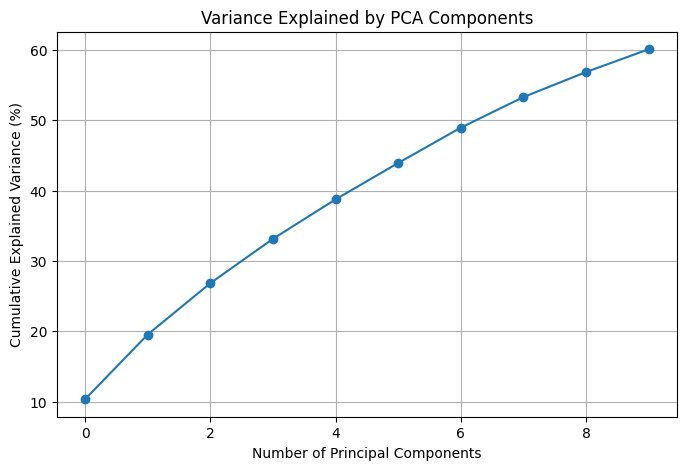

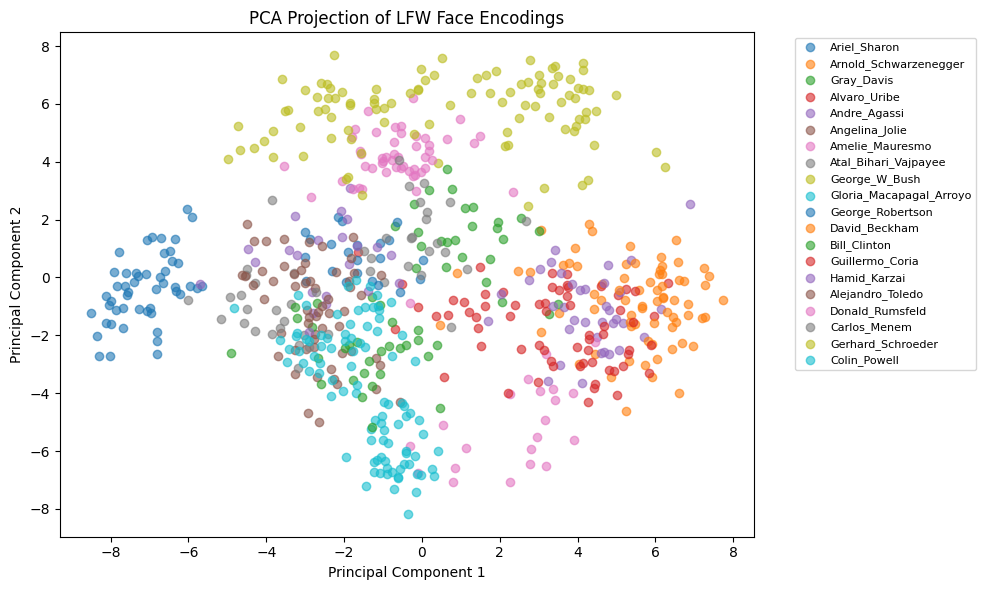

✅ Day 2 complete — Database & PCA Analysis finished.


In [4]:
# =========================================================
# Database Integration & Feature Analysis (using DeepFace)
# =========================================================

# Step 0: Environment setup
!pip install deepface --quiet
!pip install opencv-python pandas matplotlib scikit-learn --quiet

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU for simplicity

import cv2
import pandas as pd
import numpy as np
from deepface import DeepFace
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sqlite3
import joblib # Import joblib to save the PCA model

# Step 1: Encode all faces (from LFW dataset)
data_dir = "data/known_faces"
encodings, labels = [], []

print("🔍 Encoding faces from dataset (DeepFace)...")
for person_name in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person_name)
    if not os.path.isdir(person_path):
        continue
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        try:
            embedding = DeepFace.represent(img_path, model_name='Facenet', enforce_detection=False)[0]["embedding"]
            encodings.append(embedding)
            labels.append(person_name)
        except Exception as e:
            print(f"⚠️ Error reading {img_path}: {e}")

print(f"✅ Encoded {len(encodings)} faces from {len(set(labels))} people.")

# Step 2: Create DataFrame
df = pd.DataFrame(encodings)
df["label"] = labels
print("📋 Encoding sample:\n", df.head())

# Save CSV
df.to_csv("lfw_face_encodings.csv", index=False)
print("💾 Saved encodings to lfw_face_encodings.csv")

# Step 3: Store in SQLite database
conn = sqlite3.connect("lfw_faces.db")
df.to_sql("faces_table", conn, if_exists="replace", index=False)
conn.commit()
conn.close()
print("✅ Stored face encodings in lfw_faces.db")

# Step 4: Read back from DB (Optional: for verification)
# conn = sqlite3.connect("lfw_faces.db")
# df_db = pd.read_sql_query("SELECT * FROM faces_table", conn)
# conn.close()
# print(f"📊 Loaded {df_db.shape[0]} rows and {df_db.shape[1]} columns from database.")


# Step 5: PCA (Feature Reduction)
X = df.drop(columns=["label"]).values
pca = PCA(n_components=10)
reduced = pca.fit_transform(X)
variance_ratio = np.round(pca.explained_variance_ratio_ * 100, 2)
print("Explained Variance Ratio (%):", variance_ratio)

# Save PCA model
pca_filename = "pca_model.pkl"
joblib.dump(pca, pca_filename)
print(f"💾 Saved PCA model to {pca_filename}")


# Save reduced dataset
df_reduced = pd.DataFrame(reduced, columns=[f"PC{i+1}" for i in range(10)])
df_reduced["label"] = df["label"] # Use labels from original df
df_reduced.to_csv("lfw_faces_reduced.csv", index=False)
print("💾 Saved PCA-reduced features to lfw_faces_reduced.csv")

# Step 6: Visualizations

# (A) Variance explained
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Variance Explained by PCA Components")
plt.grid(True)
plt.show()

# (B) 2D PCA scatter plot
plt.figure(figsize=(10,6))
unique_labels = df_reduced["label"].unique()
for person in unique_labels:
    data = df_reduced[df_reduced["label"] == person]
    plt.scatter(data["PC1"], data["PC2"], label=person, alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of LFW Face Encodings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print("✅ Day 2 complete — Database & PCA Analysis finished.")

## Objective 3
- To train an SVM classifier on the face encodings to recognize individuals.


In [ ]:
# =============================================
# Model Training & Prediction (SVM Classifier)
# =============================================

# Step 0: Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib # Import joblib to save the model

# Step 1: Load Encoded Dataset
# You can choose either the full encoding or the PCA-reduced one
df = pd.read_csv("lfw_faces_reduced.csv")  # or "lfw_face_encodings.csv" if you skipped PCA

print("📂 Dataset loaded:", df.shape)
print(df.head())

# Step 2: Prepare Features and Labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Split into training and testing sets (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ Train size: {X_train.shape}, Test size: {X_test.shape}")

# Step 3: Train SVM Model
print("🧠 Training SVM classifier...")
model = SVC(kernel="linear", probability=True)
model.fit(X_train, y_train)

# Step 3a: Save the trained model
model_filename = "svm_128D_model.pkl" # Naming convention: svm_DimensionsOfFeatures_model.pkl
joblib.dump(model, model_filename)
print(f"💾 Saved trained SVM model to {model_filename}")


# Step 4: Predictions & Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {accuracy*100:.2f}%")

# Step 5: Confusion Matrix
# Select top N labels for clearer visualization
top_n = 10
label_counts = pd.Series(y_test).value_counts()
top_labels = label_counts.nlargest(top_n).index.tolist()

# Map labels to 'Other' if not in top_labels
y_test_filtered = [label if label in top_labels else 'Other' for label in y_test]
y_pred_filtered = [label if label in top_labels else 'Other' for label in y_pred]

# Get unique labels from the filtered lists
unique_filtered_labels = sorted(list(set(y_test_filtered + y_pred_filtered)))

cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=unique_filtered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_filtered_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix — Face Recognition (SVM) - Top {top_n} Labels + Other")
plt.tight_layout()
plt.show()


## Objective 4
- To develop a basic attendance system that recognizes faces from new images and logs attendance.

✅ Loaded SVM model from svm_128D_model.pkl
✅ Loaded PCA model from pca_model.pkl

📸 Please upload test images for recognition:


Saving test2.jpg to test2.jpg
Saving jolie.jpg to jolie.jpg

🔍 Recognizing faces in uploaded images...
✅ Recognized test2.jpg as: Arnold_Schwarzenegger (Confidence: 0.33)
🟩 Attendance marked for Arnold_Schwarzenegger at 08:53:33
✅ Recognized jolie.jpg as: Angelina_Jolie (Confidence: 0.33)
🟩 Attendance marked for Angelina_Jolie at 08:53:34

📋 Current Attendance Records:


,Name,Date,Time
0,Arnold_Schwarzenegger,2025-10-27,08:53:33
1,Angelina_Jolie,2025-10-27,08:53:34


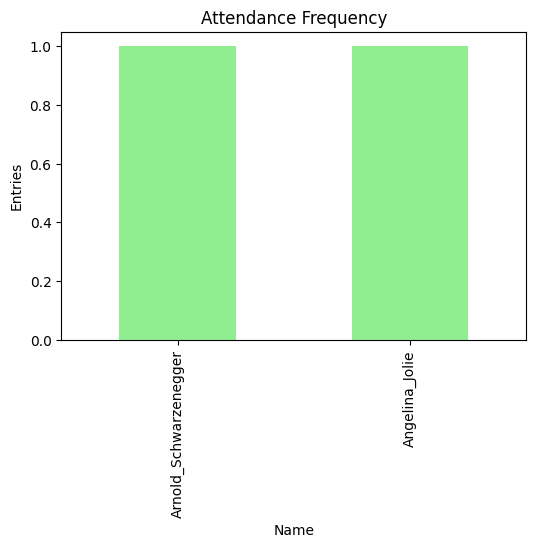

In [ ]:
# ===================================
# Recognize Multiple Uploaded Images
# ===================================

# Step 0: Imports
import os, datetime
import pandas as pd
import numpy as np
from deepface import DeepFace
import matplotlib.pyplot as plt
from google.colab import files
import joblib
from sklearn.svm import SVC
import time # Import time module

# Remove existing attendance file if it exists (Optional - keep for fresh start each run, or remove to persist)
# if os.path.exists("attendance.csv"):
#     os.remove("attendance.csv")
#     print("🗑️ Removed existing attendance.csv file.")

# Step 1: Load the saved SVM model
try:
    model = joblib.load("svm_128D_model.pkl")
    print("✅ Loaded SVM model from svm_128D_model.pkl")
except FileNotFoundError:
    print("⚠️ SVM model not found! Please run the previous cell to train and save the model.")
    model = None # Set model to None if not found

# Load the saved PCA model
try:
    pca_model = joblib.load("pca_model.pkl")
    print("✅ Loaded PCA model from pca_model.pkl")
except FileNotFoundError:
    print("⚠️ PCA model not found! Please run Objective 2 to train and save the PCA model.")
    pca_model = None # Set pca_model to None if not found


# Variable to store the name of the last person whose attendance was marked
last_marked_person = None
# Dictionary to store the last time attendance was marked for each person
last_attendance_time = {}
# Cooldown period in seconds (e.g., 60 seconds)
ATTENDANCE_COOLDOWN = 3600 # Changed cooldown to 1 hour (3600 seconds)


# Step 2: Upload test images
if model is not None and pca_model is not None: # Ensure both models are loaded
    print("\n📸 Please upload test images for recognition:")
    uploaded = files.upload()

    # Step 3: Attendance logging function (re-defined for this cell)
    def mark_attendance(name):
        global last_marked_person
        global last_attendance_time

        now = datetime.datetime.now()
        current_time = time.time()

        # Check if attendance file exists and read it
        if os.path.exists("attendance.csv"):
            df_attendance = pd.read_csv("attendance.csv")
            # Check if the person is already in the attendance list, but allow multiple 'Unidentified' entries
            if name != "Unidentified" and name in df_attendance["Name"].values:
                print(f"Skipping attendance for {name} - already recorded.")
                return # Skip marking attendance if the person is already recorded and not 'Unidentified'

        # Check if attendance was marked recently for this person (cooldown)
        if name in last_attendance_time and (current_time - last_attendance_time[name]) < ATTENDANCE_COOLDOWN:
            # print(f"Skipping attendance for {name} - cooldown active.") # Optional: for debugging
            return # Skip marking attendance if cooldown is active


        entry = {'Name': name, 'Date': now.date(), 'Time': now.strftime("%H:%M:%S")}
        df_entry = pd.DataFrame([entry])

        if not os.path.exists("attendance.csv"):
            df_entry.to_csv("attendance.csv", mode="w", header=True, index=False)
        else:
            df_entry.to_csv("attendance.csv", mode="a", header=False, index=False)

        if name != "Unidentified":
            print(f"🟩 Attendance marked for {name} at {entry['Time']}")
            last_marked_person = name # Update the last marked person
            last_attendance_time[name] = current_time # Update the last marked time for this person
        else:
            print(f"🟥 Unidentified face detected at {entry['Time']}")
            last_marked_person = None # Reset if unidentified


    # Step 4: Recognize faces in uploaded images
    print("\n🔍 Recognizing faces in uploaded images...")
    # Define a confidence threshold (adjust as needed)
    CONFIDENCE_THRESHOLD = 0.25 # Lowered threshold

    for img_name, img_data in uploaded.items():
        test_img_path = img_name
        # Save the uploaded file temporarily
        with open(test_img_path, 'wb') as f:
            f.write(img_data)

        try:
            embedding = DeepFace.represent(
                img_path=test_img_path,
                model_name="Facenet",
                enforce_detection=False,
                detector_backend="opencv"
            )[0]["embedding"]
            test_emb = np.array(embedding).reshape(1, -1)

            # Apply PCA transformation to the embedding
            test_emb_reduced = pca_model.transform(test_emb)


            # Get prediction and probability
            probabilities = model.predict_proba(test_emb_reduced)[0] # Use reduced features
            max_prob_index = np.argmax(probabilities)
            max_probability = probabilities[max_prob_index]
            predicted_name = model.classes_[max_prob_index]

            if max_probability >= CONFIDENCE_THRESHOLD:
                pred_name = predicted_name
                print(f"✅ Recognized {img_name} as: {pred_name} (Confidence: {max_probability:.2f})")
                mark_attendance(pred_name)
            else:
                pred_name = "Unidentified"
                print(f"❓ Could not identify {img_name} (Confidence: {max_probability:.2f})")
                mark_attendance(pred_name)


        except Exception as e:
            print(f"⚠️ Recognition error for {img_name}: {e}")
            mark_attendance("Error") # Log 'Error' for images that cause exceptions
        finally:
            # Clean up the temporary file
            if os.path.exists(test_img_path):
                os.remove(test_img_path)

    # Step 5: Display attendance log
    if os.path.exists("attendance.csv"):
        df_att = pd.read_csv("attendance.csv")
        if not df_att.empty:
            print("\n📋 Current Attendance Records:")
            display(df_att.tail()) # Use display for better formatting

            # Attendance frequency bar plot
            plt.figure(figsize=(6,4))
            df_att["Name"].value_counts().plot(kind="bar", color="lightgreen")
            plt.title("Attendance Frequency")
            plt.xlabel("Name")
            plt.ylabel("Entries")
            plt.show()
        else:
            print("⚠️ Attendance file exists but has no data yet.")
    else:
        print("⚠️ No attendance records yet.")

📊 Generating ROC curves...


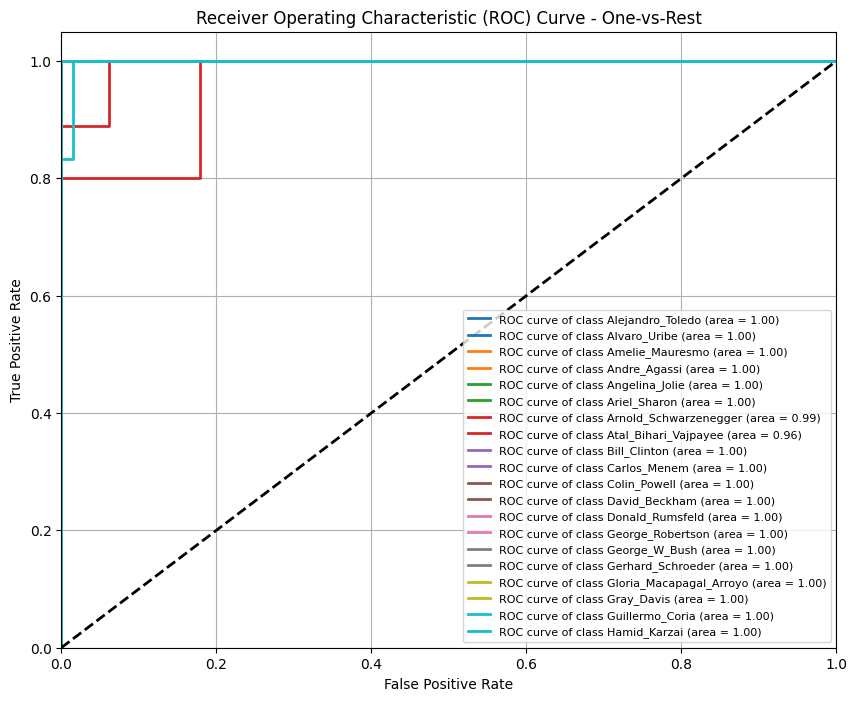

✅ ROC curve analysis complete.


In [ ]:
# =====================================================
# ROC Curve Analysis (Pre-Webcam Integration)
# =====================================================

# Step 0: Imports
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas to load the CSV
from sklearn.svm import SVC # Import SVC to train the temporary model
from sklearn.model_selection import train_test_split # Import train_test_split

print("📊 Generating ROC curves...")

# Step 1: Load the PCA-reduced dataset and prepare data
try:
    df_reduced = pd.read_csv("lfw_faces_reduced.csv")
    X = df_reduced.drop(columns=["label"]).values
    y = df_reduced["label"].values

    # Split data to get the same test set as used for training
    # This assumes the same random_state and test_size were used in the training cell (k1f_NXY1oA7u)
    # If not, the ROC curve might not perfectly reflect the reported accuracy.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Step 2: Train a temporary SVM model for ROC analysis
    # This ensures the model is trained on the 10-feature data
    temp_model = SVC(kernel="linear", probability=True)
    temp_model.fit(X_train, y_train)

    # Step 3: Binarize the output labels for multi-class ROC
    classes = temp_model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]

    # Step 4: Get the probability estimates for the test set using the temporary model
    y_pred_proba = temp_model.predict_proba(X_test)

    # Step 5: Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Step 6: Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10', n_classes) # Use a colormap for different classes

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Diagonal random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()

    print("✅ ROC curve analysis complete.")

except FileNotFoundError:
    print("⚠️ Error: 'lfw_faces_reduced.csv' not found. Please ensure the PCA reduction step (Objective 2) was run successfully.")
except AttributeError:
     print("⚠️ Error: Could not get probability estimates. Please ensure 'probability=True' was set when training the SVM model.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# =====================================
# F1 Score Calculation
# =====================================

# Step 0: Imports
from sklearn.metrics import f1_score
import numpy as np

# Ensure y_test and y_pred from the model training cell (Objective 3) are available
# If you re-ran the previous cell, these variables should be in memory.
# If not, you may need to re-run the model training cell (Objective 3).

if 'y_test' not in locals() or 'y_pred' not in locals():
    print("⚠️ Test data or predictions not found. Please run the SVM training cell (Objective 3) first.")
else:
    print("📊 Calculating F1 Score...")

    # Step 1: Calculate the F1 score
    # Use average='weighted' for multi-class classification to account for label imbalance.
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"✅ F1 Score (weighted): {f1:.2f}")

    print("✅ F1 score calculation complete.")

📊 Calculating F1 Score...
✅ F1 Score (weighted): 0.96
✅ F1 score calculation complete.


In [ ]:
# =====================================
# Cohen's Kappa Calculation
# =====================================

# Step 0: Imports
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Ensure y_test and y_pred from the model training cell (Objective 3) are available
# If you re-ran the previous cell, these variables should be in memory.
# If not, you may need to re-run the model training cell (Objective 3).

if 'y_test' not in locals() or 'y_pred' not in locals():
    print("⚠️ Test data or predictions not found. Please run the SVM training cell (Objective 3) first.")
else:
    print("📊 Calculating Cohen's Kappa Score...")

    # Step 1: Calculate Cohen's Kappa score
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"✅ Cohen's Kappa Score: {kappa:.2f}")

    print("✅ Cohen's Kappa score calculation complete.")

📊 Calculating Cohen's Kappa Score...
✅ Cohen's Kappa Score: 0.96
✅ Cohen's Kappa score calculation complete.
